# 量子分类器

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

本教程我们将讨论量子分类器（quantum classifier）的原理，以及如何利用量子神经网络（quantum neural network, QNN）来完成**两分类**任务。这类方法早期工作的主要代表是 Mitarai et al.(2018) 的量子电路学习 [(Quantum Circuit Learning, QCL)](https://arxiv.org/abs/1803.00745) [1], Farhi & Neven (2018) [2] 和 Schuld et al.(2018) 的中心电路量子分类器 [Circuit-Centric Quantum Classifiers](https://arxiv.org/abs/1804.00633) [3]。这里我们以第一类的 QCL 框架应用于监督学习（Supervised learning）为例进行介绍，通常我们需要先将经典数据编码成量子数据，然后通过训练量子神经网络的参数，最终得到一个最优的分类器。

### 背景

在监督学习的情况下，我们需要输入 $N$ 组带标签的数据点构成的数据集 $D = \{(x^k,y^k)\}_{k=1}^{N}$，其中 $x^k\in \mathbb{R}^{m}$ 是数据点，$y^k \in\{0,1\}$ 是对应数据点 $x^k$ 的分类标签。**分类过程实质上是一个决策过程，决策给定数据点的标签归属问题**。 对于量子分类器框架，分类器 $\mathcal{F}$ 的实现方式为一个含参 $\theta$ 的量子神经网络/参数化量子电路, 测量量子系统以及数据后处理的组合。一个优秀的分类器 $\mathcal{F}_\theta$ 应该尽可能的将每个数据集内的数据点正确地映射到相对应的标签上 $\mathcal{F}_\theta(x^k) \rightarrow y^k$。因此，我们将预测标签 $\tilde{y}^{k} = \mathcal{F}_\theta(x^k)$ 和实际标签 $y^k$ 之间的累计距离作为损失函数 $\mathcal{L}(\theta)$ 进行优化。对于两分类任务，可以选择二次损失函数

$$
\mathcal{L}(\theta) = \sum_{k=1}^N |\tilde{y}^{k}-y^k|^2. \tag{1}
$$



### 方案流程

这里我们给出实现量子电路学习 (QCL) 框架下量子分类器的一个流程。

1. 在初始化的量子比特 $\lvert 0 \rangle$ 上作用参数化的酉门 $U$（unitary gate），从而把原始的经典数据点 $x^k$ 编码成量子计算机可以运行的量子数据 $\lvert \psi_{in}\rangle^k$。
2. 使输入态 $\lvert \psi_{in} \rangle^k$ 通过参数为 $\theta$ 的参数化电路 $U(\theta)$ ，由此获得输出态 $\lvert \psi_{out}\rangle^k = U(\theta)\lvert \psi_{in} \rangle^k$。
3. 对量子神经网络处理后的量子态 $\lvert \psi_{out}\rangle^k$ 进行测量和数据后处理，得到估计出的标签 $\tilde{y}^{k}$。
4. 重复步骤2-3直到数据集内所有的数据点都经过了处理。然后计算损失函数 $\mathcal{L}(\theta)$。
5. 通过梯度下降等优化方法不断调整参数 $\theta$ 的值，从而最小化损失函数。记录优化完成后的最优参数 $\theta^*$, 这时我们就学习到了最优的分类器 $\mathcal{F}_{\theta^*}$。



![QCL](figures/qclassifier-fig-pipeline-cn.png "图 1：量子分类器训练的流程图")
<div style="text-align:center">图 1：量子分类器训练的流程图 </div>

## Paddle Quantum 实现

这里，我们先导入所需要的语言包：


In [1]:
import time
import matplotlib
import numpy as np
import paddle
from numpy import pi as PI
from matplotlib import pyplot as plt

from paddle import matmul, transpose
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

In [2]:
# 这是教程中会用到的几个主要函数
__all__ = [
    "circle_data_point_generator",
    "data_point_plot",
    "heatmap_plot",
    "Ry",
    "Rz",
    "Observable",
    "U_theta",
    "Net",
    "QC",
    "main",
]

### 数据集的生成

对于监督学习来说，我们绕不开的一个问题就是——采用的数据集是什么样的？在这个教程中我们按照论文 [1] 里所提及方法生成简单的圆形决策边界二分数据集 $\{(x^{k}, y^{k})\}$。其中数据点 $x^{k}\in \mathbb{R}^{2}$，标签 $y^{k} \in \{0,1\}$。

![数据集](figures/qclassifier-fig-data-cn.png "图 2：生成的数据集和对应的决策边界")
<div style="text-align:center">图 2：生成的数据集和对应的决策边界 </div>

具体的生成方式和可视化请见如下代码：

In [3]:
# 圆形决策边界两分类数据集生成器
def circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data):
    """
    :param Ntrain: 训练集大小
    :param Ntest: 测试集大小
    :param boundary_gap: 取值于 (0, 0.5), 两类别之间的差距
    :param seed_data: 随机种子
    :return: 'Ntrain' 训练集
             'Ntest' 测试集
    """
    train_x, train_y = [], []
    num_samples, seed_para = 0, 0
    while num_samples < Ntrain + Ntest:
        np.random.seed((seed_data + 10) * 1000 + seed_para + num_samples)
        data_point = np.random.rand(2) * 2 - 1

        # 如果数据点的模小于(0.7 - gap)，标为0
        if np.linalg.norm(data_point) < 0.7 - boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(0.)
            num_samples += 1

        # 如果数据点的模大于(0.7 + gap)，标为1
        elif np.linalg.norm(data_point) > 0.7 + boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(1.)
            num_samples += 1
        else:
            seed_para += 1

    train_x = np.array(train_x).astype("float64")
    train_y = np.array([train_y]).astype("float64").T

    print("训练集的维度大小 x {} 和 y {}".format(np.shape(train_x[0:Ntrain]), np.shape(train_y[0:Ntrain])))
    print("测试集的维度大小 x {} 和 y {}".format(np.shape(train_x[Ntrain:]), np.shape(train_y[Ntrain:])), "\n")

    return train_x[0:Ntrain], train_y[0:Ntrain], train_x[Ntrain:], train_y[Ntrain:]


# 用以可视化生成的数据集
def data_point_plot(data, label):
    """
    :param data: 形状为 [M, 2], 代表 M 2-D 数据点
    :param label: 取值 0 或者 1
    :return: 画这些数据点
    """
    dim_samples, dim_useless = np.shape(data)
    plt.figure(1)
    for i in range(dim_samples):
        if label[i] == 0:
            plt.plot(data[i][0], data[i][1], color="r", marker="o")
        elif label[i] == 1:
            plt.plot(data[i][0], data[i][1], color="b", marker="o")
    plt.show()

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

训练集 200 个数据点的可视化：


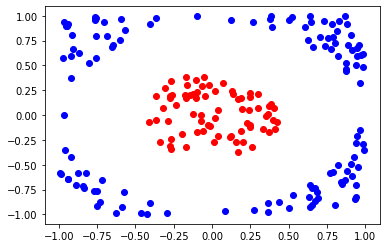

测试集 100 个数据点的可视化：


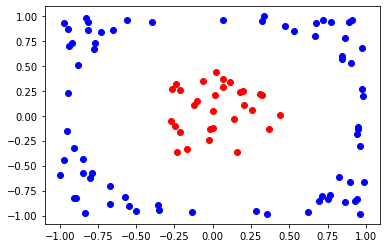


 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！


In [4]:
# 数据集参数设置
Ntrain = 200        # 规定训练集大小
Ntest = 100         # 规定测试集大小
boundary_gap = 0.5  # 设置决策边界的宽度
seed_data = 2       # 固定随机种子

# 生成自己的数据集
train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data)

# 打印数据集的维度信息
print("训练集 {} 个数据点的可视化：".format(Ntrain))
data_point_plot(train_x, train_y)
print("测试集 {} 个数据点的可视化：".format(Ntest))
data_point_plot(test_x, test_y)
print("\n 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！")

### 数据的预处理

与经典机器学习不同的是，量子分类器在实际工作的时候需要考虑数据的预处理。我们需要多加一个步骤将经典的数据转化成量子信息才能放在量子计算机上运行。接下来我们看看具体是怎么完成的。

首先我们确定需要使用的量子比特数量。因为我们的数据 $\{x^{k} = (x^{k}_0, x^{k}_1)\}$ 是二维的, 按照 Mitarai (2018) 论文[1]中的编码方式我们至少需要2个量子比特。接着准备一系列的初始量子态 $|00\rangle$。然后将经典信息 $\{x^{k}\}$ 编码成一系列量子门 $U(x^{k})$ 并作用在初始量子态上。最终得到一系列的量子态 $|\psi\rangle^k = U(x^{k})|00\rangle$。这样我们就完成从经典信息到量子信息的编码了！给定 $m$ 个量子比特去编码二维的经典数据点，则量子门的构造为：

$$
U(x^{k}) = \otimes_{j=0}^{m-1} R_j^z\big[\arccos(x_{j \, \text{mod} \, 2}\cdot x_{j \, \text{mod} \, 2})\big] R_j^y\big[\arcsin(x_{j \, \text{mod} \, 2}) \big],\tag{2}
$$

**注意** ：这种表示下，我们将第一个量子比特编号为 $j = 0$。更多编码方式见 [Robust data encodings for quantum classifiers](https://arxiv.org/pdf/2003.01695.pdf)。读者也可以直接使用量桨中提供的[编码方式](./DataEncoding_CN.ipynb)。这里我们也欢迎读者自己创新尝试全新的编码方式。
由于这种编码的方式看着比较复杂，我们不妨来举一个简单的例子。假设我们给定一个数据点 $x = (x_0, x_1)= (1,0)$, 显然这个数据点的标签应该为 1，对应上图**蓝色**的点。同时数据点对应的2比特量子门 $U(x)$ 是

$$
U(x) = 
\bigg( R_0^z\big[\arccos(x_{0}\cdot x_{0})\big] R_0^y\big[\arcsin(x_{0}) \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\arccos(x_{1}\cdot x_{1})\big] R_1^y\big[\arcsin(x_{1}) \big] \bigg),\tag{3}
$$


把具体的数值带入我们就能得到：
$$
U(x) = 
\bigg( R_0^z\big[0\big] R_0^y\big[\pi/2 \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\pi/2\big] R_1^y\big[0 \big] \bigg),
\tag{4}
$$

以下是常用的旋转门的矩阵形式：


$$
R_x(\theta) := 
\begin{bmatrix} 
\cos \frac{\theta}{2} &-i\sin \frac{\theta}{2} \\ 
-i\sin \frac{\theta}{2} &\cos \frac{\theta}{2} 
\end{bmatrix}
,\quad 
R_y(\theta) := 
\begin{bmatrix}
\cos \frac{\theta}{2} &-\sin \frac{\theta}{2} \\ 
\sin \frac{\theta}{2} &\cos \frac{\theta}{2} 
\end{bmatrix}
,\quad 
R_z(\theta) := 
\begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\ 
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}. \tag{5}
$$

那么这个两比特量子门 $U(x)$ 的矩阵形式可以写为：

$$
U(x) = 
\bigg(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \frac{\pi}{4} &-\sin \frac{\pi}{4} \\ 
\sin \frac{\pi}{4} &\cos \frac{\pi}{4} 
\end{bmatrix}
\bigg)
\otimes 
\bigg(
\begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\ 
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
1 &0 \\ 
0 &1
\end{bmatrix}
\bigg),\tag{6}
$$

化简后我们作用在零初始化的 $|00\rangle$ 量子态上可以得到编码后的量子态 $|\psi\rangle$，

$$
|\psi\rangle =
U(x)|00\rangle = \frac{1}{2}
\begin{bmatrix}
1-i &0 &-1+i &0 \\ 
0 &1+i &0  &-1-i \\
1-i &0 &1-i  &0 \\
0 &1+i &0  &1+i 
\end{bmatrix}
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.\tag{7}
$$

接着我们来看看代码上怎么实现这种编码方式。需要注意的是：代码中使用了一个张量积来表述

$$
(U_1 |0\rangle)\otimes (U_2 |0\rangle) = (U_1 \otimes U_2) |0\rangle\otimes|0\rangle
= (U_1 \otimes U_2) |00\rangle.\tag{8}
$$

In [5]:
def Ry(theta):
    """
    :param theta: 参数
    :return: Y 旋转矩阵
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def Rz(theta):
    """
    :param theta: 参数
    :return: Z 旋转矩阵
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# 经典 -> 量子数据编码器
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: 形状为 [-1, 2]
    :param n_qubits: 数据转化后的量子比特数量
    :return: 形状为 [-1, 1, 2 ^ n_qubits]
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        for i in range(n_qubits):
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            elif i % 2 == 1:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)

    res = np.array(res)
    return res.astype("complex128")

print("作为测试我们输入以上的经典信息:")
print("(x_0, x_1) = (1, 0)")
print("编码后输出的2比特量子态为:")
print(datapoints_transform_to_state(np.array([[1, 0]]), n_qubits=2))

作为测试我们输入以上的经典信息:
(x_0, x_1) = (1, 0)
编码后输出的2比特量子态为:
[[[0.5-0.5j 0. +0.j  0.5-0.5j 0. +0.j ]]]


### 构造量子神经网络

那么在完成上述从经典数据到量子数据的编码后，我们现在可以把这些量子态输入到量子计算机里面了。在那之前，我们还需要设计下我们所采用的量子神经网络结构。

![电路结构](figures/qclassifier-fig-circuit.png "图 3：参数化量子神经网络的电路结构")
<div style="text-align:center">图 3：参数化量子神经网络的电路结构 </div>


为了方便，我们统一将上述参数化的量子神经网络称为 $U(\boldsymbol{\theta})$。这个 $U(\boldsymbol{\theta})$ 是我们分类器的关键组成部分，需要一定的复杂结构来拟合我们的决策边界。与经典神经网络类似，量子神经网络的的设计并不是唯一的，这里展示的仅仅是一个例子，读者不妨自己设计出自己的量子神经网络。我们还是拿原来提过的这个数据点 $x = (x_0, x_1)= (1,0)$ 来举例子，编码过后我们已经得到了一个量子态 $|\psi\rangle$，

$$
|\psi\rangle =
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix},\tag{9}
$$

接着我们把这个量子态输入进我们的量子神经网络，也就是把一个酉矩阵乘以一个向量。得到处理过后的量子态 $|\varphi\rangle$

$$
|\varphi\rangle = U(\boldsymbol{\theta})|\psi\rangle,\tag{10}
$$

如果我们把所有的参数 $\theta$ 都设置为 $\theta = \pi$, 那么我们就可以写出具体的矩阵了：

$$
|\varphi\rangle = 
U(\boldsymbol{\theta} =\pi)|\psi\rangle =
\begin{bmatrix}
0  &0 &-1 &0 \\ 
-1 &0 &0  &0 \\
0  &1 &0  &0 \\
0  &0 &0  &1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}.\tag{11}
$$

In [6]:
# 模拟搭建量子神经网络
def U_theta(theta, n, depth):  
    """
    :param theta: 维数: [n, depth + 3]
    :param n: 量子比特数量
    :param depth: 电路深度
    :return: U_theta
    """
    # 初始化网络
    cir = UAnsatz(n)
    
    # 先搭建广义的旋转层
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # 默认深度为 depth = 1
    # 搭建纠缠层和 Ry旋转层
    for d in range(3, depth + 3):
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir

### 测量与损失函数

当我们在量子计算机上（QPU）用量子神经网络处理过初始量子态 $|\psi\rangle$ 后， 我们需要重新测量这个新的量子态 $|\varphi\rangle$ 来获取经典信息。这些处理过后的经典信息可以用来计算损失函数 $\mathcal{L}(\boldsymbol{\theta})$。最后我们再通过经典计算机（CPU）来不断更新QNN参数 $\boldsymbol{\theta}$ 并优化损失函数。这里我们采用的测量方式是测量泡利 $Z$ 算符在第一个量子比特上的期望值。 具体来说，

$$
\langle Z \rangle = 
\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle,\tag{12}
$$

复习一下，泡利 $Z$ 算符的矩阵形式为：

$$
Z := \begin{bmatrix} 1 &0 \\ 0 &-1 \end{bmatrix},\tag{13}
$$

继续我们前面的 2 量子比特的例子，测量过后我们得到的期望值就是：
$$
\langle Z \rangle = 
\langle \varphi |Z\otimes I| \varphi\rangle = 
\frac{1}{2}
\begin{bmatrix}
-1-i \quad
-1-i \quad
0   \quad
0
\end{bmatrix}
\begin{bmatrix}
1  &0 &0  &0 \\ 
0  &1 &0  &0 \\
0  &0 &-1 &0 \\
0  &0 &0  &-1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
= 1,\tag{14}
$$

好奇的读者或许会问，这个测量结果好像就是我们原来的标签 1 ，这是不是意味着我们已经成功的分类这个数据点了？其实并不然，因为 $\langle Z \rangle$ 的取值范围通常在 $[-1,1]$之间。 为了对应我们的标签范围 $y^{k} \in \{0,1\}$, 我们还需要将区间上下限映射上。这个映射最简单的做法就是让

$$
\tilde{y}^{k} = \frac{\langle Z \rangle}{2} + \frac{1}{2} + bias \quad \in [0, 1].\tag{15}
$$

其中加入偏置（bias）是机器学习中的一个小技巧，目的就是为了让决策边界不受制于原点或者一些超平面。一般我们默认偏置初始化为0，并且优化器在迭代过程中会类似于参数 $\theta$ 一样不断更新偏置确保 $\tilde{y}^{k} \in [0, 1]$。当然读者也可以选择其他复杂的映射（激活函数）比如说 sigmoid 函数。映射过后我们就可以把 $\tilde{y}^{k}$ 看作是我们估计出的标签（label）了。如果 $\tilde{y}^{k}< 0.5$ 就对应标签 0，如果 $\tilde{y}^{k}> 0.5$  就对应标签 1。 我们稍微复习一下整个流程，


$$
x^{k} \rightarrow |\psi\rangle^{k} \rightarrow U(\boldsymbol{\theta})|\psi\rangle^{k} \rightarrow
|\varphi\rangle^{k} \rightarrow ^{k}\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle^{k}
\rightarrow \langle Z \rangle  \rightarrow \tilde{y}^{k}.\tag{16}
$$

最后我们就可以把损失函数定义为平方损失函数：

$$
\mathcal{L} = \sum_{k} |y^{k} - \tilde{y}^{k}|^2.\tag{17}
$$



In [7]:
# 生成只作用在第一个量子比特上的泡利 Z 算符
# 其余量子比特上都作用单位矩阵
def Observable(n):
    r"""
    :param n: 量子比特数量
    :return: 局部可观测量: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)
    return Ob

In [8]:
# 搭建整个优化流程图
class Net(paddle.nn.Layer):
    """
    创建模型训练网络
    """
    def __init__(self,
                 n,      # 量子比特数量
                 depth,  # 电路深度
                 seed_paras=1,
                 dtype='float64'):
        super(Net, self).__init__()

        self.n = n
        self.depth = depth
        
        # 初始化参数列表 theta，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(
            shape=[n, depth + 3],
            default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
            dtype=dtype,
            is_bias=False)
        
        # 初始化偏置 (bias)
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype=dtype,
            is_bias=False)

    # 定义前向传播机制、计算损失函数 和交叉验证正确率
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = ((<Z> + 1)/2 + bias - label)^2
        """
        # 将 Numpy array 转换成 tensor
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = paddle.to_tensor(label)

        # 按照随机初始化的参数 theta 
        cir = U_theta(self.theta, n=self.n, depth=self.depth)
        Utheta = cir.U
        
        # 因为 Utheta是学习到的，我们这里用行向量运算来提速而不会影响训练效果
        state_out = matmul(state_in, Utheta)  # 维度 [-1, 1, 2 ** n]
        
        # 测量得到泡利 Z 算符的期望值 <Z>
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        
        # 映射 <Z> 处理成标签的估计值 
        state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5 + self.bias
        loss = paddle.mean((state_predict - label_pp) ** 2)
        
        # 计算交叉验证正确率
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), cir

### 训练效果与调参

好了， 那么定义完以上所有的概念之后我们不妨来看看实际的训练效果！

In [9]:
def heatmap_plot(net, N):
    # 生成数据点 x_y_
    Num_points = 30
    x_y_ = []
    for row_y in np.linspace(0.9, -0.9, Num_points):
        row = []
        for row_x in np.linspace(-0.9, 0.9, Num_points):
            row.append([row_x, row_y])
        x_y_.append(row)
    x_y_ = np.array(x_y_).reshape(-1, 2).astype("float64")

    # 计算预测: heat_data
    input_state_test = paddle.to_tensor(
        datapoints_transform_to_state(x_y_, N))
    loss_useless, acc_useless, state_predict, cir = net(state_in=input_state_test, label=x_y_[:, 0])
    heat_data = state_predict.reshape(Num_points, Num_points)

    # 画图
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    x_label = np.linspace(-0.9, 0.9, 3)
    y_label = np.linspace(0.9, -0.9, 3)
    ax.set_xticks([0, Num_points // 2, Num_points - 1])
    ax.set_xticklabels(x_label)
    ax.set_yticks([0, Num_points // 2, Num_points - 1])
    ax.set_yticklabels(y_label)
    im = ax.imshow(heat_data, cmap=plt.cm.RdBu)
    plt.colorbar(im)
    plt.show()

def QClassifier(Ntrain, Ntest, gap, N, D, EPOCH, LR, BATCH, seed_paras, seed_data,):
    """
    量子二分类器
    """
    # 生成数据集
    train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain=Ntrain, Ntest=Ntest, boundary_gap=gap, seed_data=seed_data)

    # 读取训练集的维度
    N_train = train_x.shape[0]
    
    paddle.seed(seed_paras)
    # 定义优化图
    net = Net(n=N, depth=D)

    # 一般来说，我们利用Adam优化器来获得相对好的收敛
    # 当然你可以改成SGD或者是RMSprop
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # 初始化寄存器存储正确率 acc 等信息
    summary_iter, summary_test_acc = [], []

    # 优化循环
    for ep in range(EPOCH):
        for itr in range(N_train // BATCH):

            # 将经典数据编码成量子态 |psi>, 维度 [-1, 2 ** N]
            input_state = paddle.to_tensor(datapoints_transform_to_state(train_x[itr * BATCH:(itr + 1) * BATCH], N))

            # 前向传播计算损失函数
            loss, train_acc, state_predict_useless, cir \
                = net(state_in=input_state, label=train_y[itr * BATCH:(itr + 1) * BATCH])
            if itr % 50 == 0:

                # 计算测试集上的正确率 test_acc
                input_state_test = paddle.to_tensor(datapoints_transform_to_state(test_x, N))
                loss_useless, test_acc, state_predict_useless, t_cir \
                    = net(state_in=input_state_test,label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                # 存储正确率 acc 等信息
                summary_iter.append(itr + ep * N_train)
                summary_test_acc.append(test_acc) 
            if (itr + 1) % 151 == 0 and ep == EPOCH - 1:
                print("训练后的电路：")
                print(cir)

            # 反向传播极小化损失函数
            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()

    # 画出 heatmap 表示的决策边界
    heatmap_plot(net, N=N)

    return summary_test_acc

以上都是我们定义的函数，下面我们将运行主程序。

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

epoch: 0 iter: 0 loss: 0.0318 train acc: 1.0000 test acc: 0.5400
epoch: 0 iter: 50 loss: 0.3359 train acc: 0.0000 test acc: 0.8200
epoch: 0 iter: 100 loss: 0.0396 train acc: 1.0000 test acc: 0.8700
epoch: 0 iter: 150 loss: 0.0952 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 0 loss: 0.1586 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 50 loss: 0.1534 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 100 loss: 0.0624 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 150 loss: 0.0883 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 0 loss: 0.1627 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 50 loss: 0.1378 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 100 loss: 0.0669 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 150 loss: 0.0860 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 0 loss: 0.1658 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 50 loss: 0.1359 train acc: 1.0000 test acc: 1.0000
epoch:

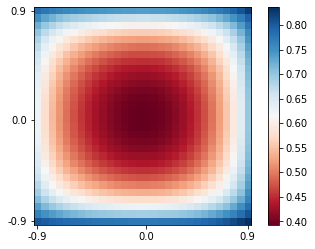

主程序段总共运行了 23.798545360565186 秒


In [10]:
def main():
    """
    主函数
    """
    time_start = time.time()
    acc = QClassifier(
        Ntrain = 200,        # 规定训练集大小
        Ntest = 100,         # 规定测试集大小
        gap = 0.5,           # 设定决策边界的宽度
        N = 4,               # 所需的量子比特数量
        D = 1,               # 采用的电路深度
        EPOCH = 4,           # 训练 epoch 轮数
        LR = 0.01,           # 设置学习速率
        BATCH = 1,           # 训练时 batch 的大小
        seed_paras = 19,     # 设置随机种子用以初始化各种参数
        seed_data = 2,       # 固定生成数据集所需要的随机种子
    )
    
    time_span = time.time() - time_start
    print('主程序段总共运行了', time_span, '秒')

if __name__ == '__main__':
    main()

通过打印训练结果可以看到不断优化后分类器在测试集和数据集的正确率都达到了 $100\%$。

---

## 参考文献

[1] Mitarai, Kosuke, et al. Quantum circuit learning. [Physical Review A 98.3 (2018): 032309.](https://arxiv.org/abs/1803.00745)

[2] Farhi, Edward, and Hartmut Neven. Classification with quantum neural networks on near term processors. [arXiv preprint arXiv:1802.06002 (2018).](https://arxiv.org/abs/1802.06002)

[3] [Schuld, Maria, et al. Circuit-centric quantum classifiers. [Physical Review A 101.3 (2020): 032308.](https://arxiv.org/abs/1804.00633)